<a href="https://colab.research.google.com/github/Upanshujha/Zeotap/blob/main/Upanshu_jha_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
# Load data
customers = pd.read_csv('/content/Customers.csv', parse_dates=['SignupDate'])
transactions = pd.read_csv('/content/Transactions.csv', parse_dates=['TransactionDate'])
products = pd.read_csv('/content/Products.csv')

In [4]:
# Merge data sources
merged_trans = pd.merge(transactions, products[['ProductID', 'Category']], on='ProductID', how='left')

In [5]:
# Transaction aggregations
transaction_features = merged_trans.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    avg_transaction=('TotalValue', 'mean'),
    transaction_count=('TransactionID', 'nunique'),
    total_quantity=('Quantity', 'sum')
).reset_index()

In [6]:
# Category features
category_counts = pd.get_dummies(merged_trans.groupby('CustomerID')['Category'].value_counts()).unstack(fill_value=0)
category_counts.columns = [f'cat_{col[1].lower()}' for col in category_counts.columns]
category_counts = category_counts.reset_index()


In [7]:
# Customer features
latest_date = transactions['TransactionDate'].max()
customers['tenure'] = (latest_date - customers['SignupDate']).dt.days

In [9]:
# Encode regions
encoder = OneHotEncoder(drop='first')
region_encoded = encoder.fit_transform(customers[['Region']]).toarray()
region_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out())

In [10]:
# Combine all features
final_df = pd.concat([customers[['CustomerID', 'tenure']], region_df], axis=1)
final_df = pd.merge(final_df, transaction_features, on='CustomerID', how='inner')
final_df = pd.merge(final_df, category_counts, on='CustomerID', how='left').fillna(0)

In [11]:
# Prepare data for clustering
X = final_df.drop('CustomerID', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Find optimal clusters using DB Index
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    db_scores.append(davies_bouldin_score(X_scaled, clusters))

optimal_k = np.argmin(db_scores) + 2


In [13]:
# Final clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_clusters = kmeans.fit_predict(X_scaled)

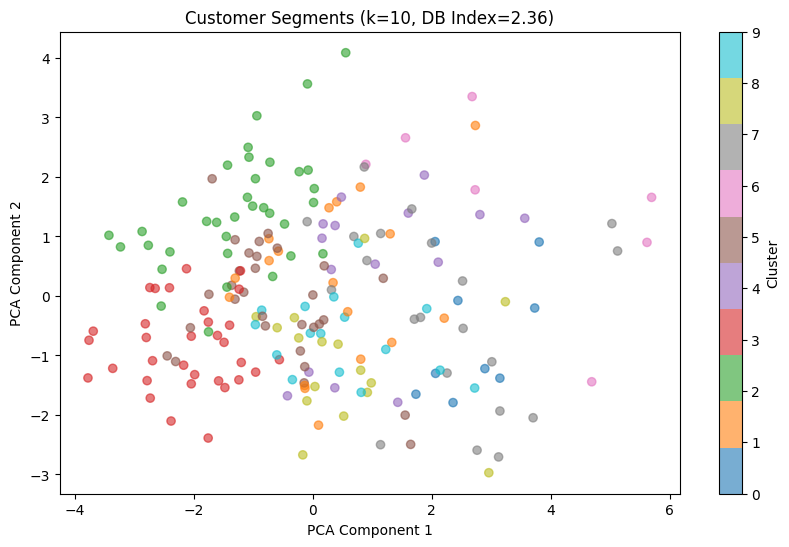

In [14]:
# Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=final_clusters, cmap='tab10', alpha=0.6)
plt.title(f'Customer Segments (k={optimal_k}, DB Index={min(db_scores):.2f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [15]:
# Print DB scores
print("Davies-Bouldin Index Scores:")
for k, score in zip(range(2, 11), db_scores):
    print(f"k={k}: {score:.3f}")

Davies-Bouldin Index Scores:
k=2: 2.952
k=3: 3.436
k=4: 3.151
k=5: 2.997
k=6: 2.610
k=7: 2.464
k=8: 2.376
k=9: 2.470
k=10: 2.358
